# BAS SC1 – ASR-Evaluierung: Whisper Large V3 vs. Parakeet TDT v3

Dieses Notebook lädt die aggregierten Ergebnisse aus `bas_sc1.csv` und vergleicht die Performance von zwei State-of-the-Art ASR-Modellen:
- **Whisper Large V3** (OpenAI)
- **Parakeet TDT v3** (NVIDIA)

Das BAS SC1-Korpus ist ein **mehrsprachiger Datensatz** mit Sprecher:innen unterschiedlicher Muttersprachen und Herkunftsländer. 
Die Word Error Rate (WER) wird in Abhängigkeit von:
- **Muttersprache** (`mother_tongue_iso639_3`)
- **Herkunftsland** (`country`)
- **L1 vs. L2 Deutsch** (Muttersprachler vs. Fremdsprachenlerner)

analysiert.

## Schritte
- Daten und Metadaten aus dem `OUTPUT_PATH` laden
- Vergleichende Kennzahlen für beide Modelle berechnen
- WER-Verteilungen beider Modelle visualisieren und vergleichen
- Muttersprachen gruppieren und analysieren
- Durchschnittliche WER je Muttersprache für beide Modelle analysieren
- L1 vs. L2 Deutsch-Sprecher:innen vergleichen
- Identifizieren, welches Modell für welche Sprachgruppen besser abschneidet

In [23]:
from __future__ import annotations

import re
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

import paths

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (10, 5)

In [24]:
output_root = Path(paths.OUTPUT_PATH or "").expanduser()
if not output_root.is_dir():
    raise FileNotFoundError("OUTPUT_PATH ist nicht gesetzt oder verweist auf kein existierendes Verzeichnis.")

csv_path = output_root / "bas_sc1.csv"
if not csv_path.is_file():
    raise FileNotFoundError(f"Erwartete Datei {csv_path} wurde nicht gefunden.")

df = pd.read_csv(csv_path)

# Convert WER columns to numeric for both models
df["whisper_large_v3_wer"] = pd.to_numeric(df["whisper_large_v3_wer"], errors="coerce")

# Check if Parakeet column exists (for backward compatibility with old CSV files)
has_parakeet = "parakeet_tdt_v3_wer" in df.columns
if has_parakeet:
    df["parakeet_tdt_v3_wer"] = pd.to_numeric(df["parakeet_tdt_v3_wer"], errors="coerce")
    print(f"✓ Beide Modelle verfügbar: Whisper Large V3 & Parakeet TDT v3")
else:
    print("⚠ Nur Whisper Large V3 verfügbar (Parakeet-Spalte fehlt in CSV)")

print(f"Anzahl Aufnahmen: {len(df):,}")

# Display relevant columns
display_cols = ["speaker_id", "mother_tongue_iso639_3", "country", "whisper_large_v3_wer"]
if has_parakeet:
    display_cols.append("parakeet_tdt_v3_wer")
df[display_cols].head()

✓ Beide Modelle verfügbar: Whisper Large V3 & Parakeet TDT v3
Anzahl Aufnahmen: 88


,speaker_id,mother_tongue_iso639_3,country,whisper_large_v3_wer,parakeet_tdt_v3_wer
0,DA01_03,ara,Syria,0.092593,0.092593
1,DA01_06,ara,Sudan,0.453704,0.111111
2,DA01_10,ara,Egypt,0.361111,0.111111
3,DA01_14,heb,Israel,0.138889,0.129630
4,DA01_22,und,Ethiopia,0.175926,0.166667


In [25]:
# Vergleichende Statistiken für beide Modelle
if has_parakeet:
    comparison_stats = pd.DataFrame({
        "Whisper Large V3": df["whisper_large_v3_wer"].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]),
        "Parakeet TDT v3": df["parakeet_tdt_v3_wer"].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
    })
    
    # Fehlende Werte
    missing_whisper = df["whisper_large_v3_wer"].isna().sum()
    missing_parakeet = df["parakeet_tdt_v3_wer"].isna().sum()
    print(f"Fehlende WER-Werte → Whisper: {missing_whisper}, Parakeet: {missing_parakeet}")
    
    comparison_stats
else:
    # Nur Whisper verfügbar
    missing = df["whisper_large_v3_wer"].isna().sum()
    print(f"Fehlende WER-Werte: {missing}")
    wer_summary = df["whisper_large_v3_wer"].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
    wer_summary.to_frame(name="Whisper Large V3")

Fehlende WER-Werte → Whisper: 0, Parakeet: 0


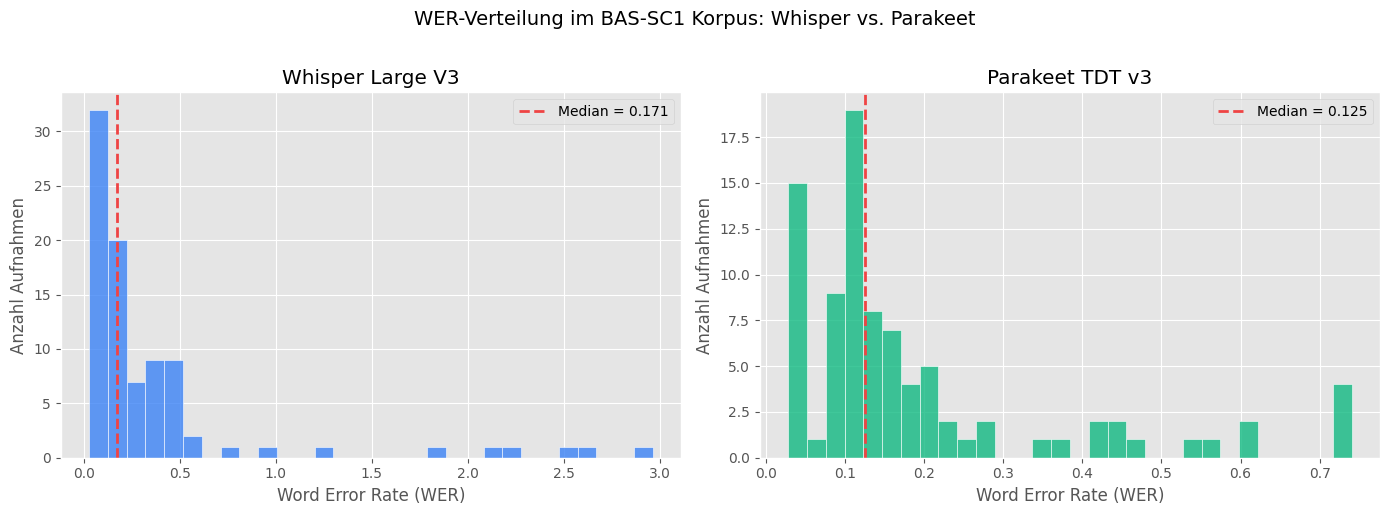

In [26]:
if has_parakeet:
    # Zwei Histogramme nebeneinander für direkten Vergleich
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Whisper Large V3
    whisper_wer = df["whisper_large_v3_wer"].dropna()
    axes[0].hist(whisper_wer, bins=30, color="#3B82F6", edgecolor="white", alpha=0.8)
    whisper_median = whisper_wer.median()
    axes[0].axvline(whisper_median, color="#EF4444", linestyle="--", linewidth=2, label=f"Median = {whisper_median:.3f}")
    axes[0].set_xlabel("Word Error Rate (WER)")
    axes[0].set_ylabel("Anzahl Aufnahmen")
    axes[0].set_title("Whisper Large V3")
    axes[0].legend()
    
    # Parakeet TDT v3
    parakeet_wer = df["parakeet_tdt_v3_wer"].dropna()
    axes[1].hist(parakeet_wer, bins=30, color="#10B981", edgecolor="white", alpha=0.8)
    parakeet_median = parakeet_wer.median()
    axes[1].axvline(parakeet_median, color="#EF4444", linestyle="--", linewidth=2, label=f"Median = {parakeet_median:.3f}")
    axes[1].set_xlabel("Word Error Rate (WER)")
    axes[1].set_ylabel("Anzahl Aufnahmen")
    axes[1].set_title("Parakeet TDT v3")
    axes[1].legend()
    
    fig.suptitle("WER-Verteilung im BAS-SC1 Korpus: Whisper vs. Parakeet", fontsize=14, y=1.02)
    plt.tight_layout()
else:
    # Nur Whisper verfügbar (Fallback)
    fig, ax = plt.subplots(figsize=(10, 4))
    wer_values = df["whisper_large_v3_wer"].dropna()
    ax.hist(wer_values, bins=30, color="#3B82F6", edgecolor="white")
    median_wer = wer_values.median()
    ax.axvline(median_wer, color="#EF4444", linestyle="--", label=f"Median = {median_wer:.3f}")
    ax.set_xlabel("Word Error Rate (WER)")
    ax.set_ylabel("Anzahl Aufnahmen")
    ax.set_title("Verteilung der Whisper-Large-V3 WER im BAS-SC1 Korpus")
    ax.legend()
    plt.tight_layout()

Verglichene Aufnahmen: 88


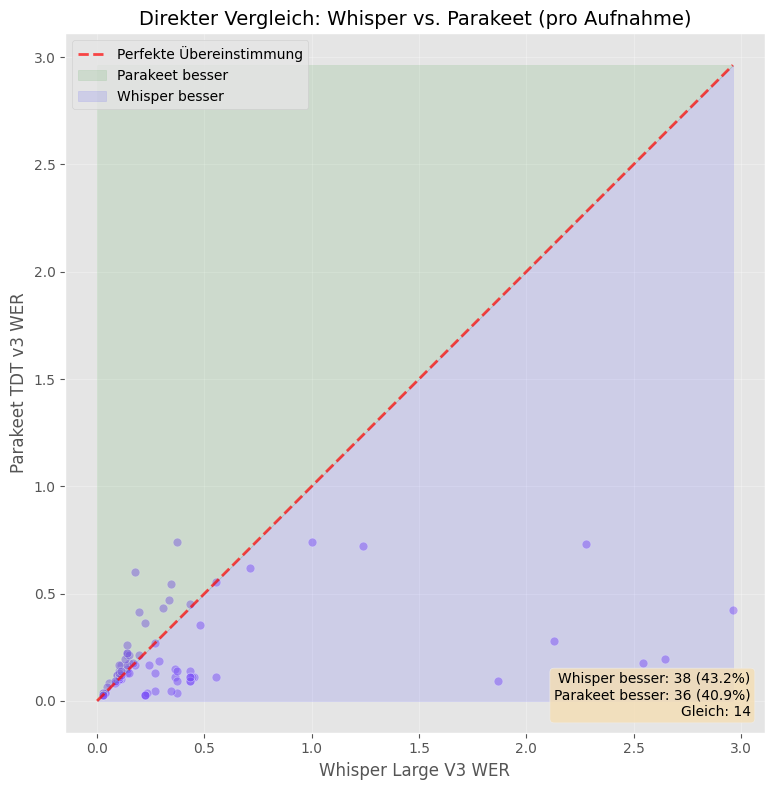

In [27]:
if has_parakeet:
    # Direkter Vergleich: Scatter-Plot Whisper vs. Parakeet
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Nur gültige Paare (beide Werte vorhanden)
    comparison_df = df[["whisper_large_v3_wer", "parakeet_tdt_v3_wer"]].dropna()
    
    ax.scatter(comparison_df["whisper_large_v3_wer"], 
               comparison_df["parakeet_tdt_v3_wer"], 
               alpha=0.5, s=40, color="#8B5CF6", edgecolors="white", linewidth=0.5)
    
    # Diagonale: Perfekte Übereinstimmung
    max_val = max(comparison_df["whisper_large_v3_wer"].max(), comparison_df["parakeet_tdt_v3_wer"].max())
    ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, alpha=0.7, label="Perfekte Übereinstimmung")
    
    # Bereiche markieren
    ax.fill_between([0, max_val], [0, max_val], max_val, alpha=0.1, color="green", label="Parakeet besser")
    ax.fill_between([0, max_val], 0, [0, max_val], alpha=0.1, color="blue", label="Whisper besser")
    
    ax.set_xlabel("Whisper Large V3 WER", fontsize=12)
    ax.set_ylabel("Parakeet TDT v3 WER", fontsize=12)
    ax.set_title("Direkter Vergleich: Whisper vs. Parakeet (pro Aufnahme)", fontsize=14)
    ax.legend(loc="upper left")
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')
    
    # Statistik anzeigen
    whisper_better = (comparison_df["whisper_large_v3_wer"] < comparison_df["parakeet_tdt_v3_wer"]).sum()
    parakeet_better = (comparison_df["parakeet_tdt_v3_wer"] < comparison_df["whisper_large_v3_wer"]).sum()
    tied = (comparison_df["whisper_large_v3_wer"] == comparison_df["parakeet_tdt_v3_wer"]).sum()
    
    stats_text = f"Whisper besser: {whisper_better} ({whisper_better/len(comparison_df)*100:.1f}%)\n"
    stats_text += f"Parakeet besser: {parakeet_better} ({parakeet_better/len(comparison_df)*100:.1f}%)\n"
    stats_text += f"Gleich: {tied}"
    
    ax.text(0.98, 0.02, stats_text, transform=ax.transAxes, 
            fontsize=10, verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    print(f"Verglichene Aufnahmen: {len(comparison_df)}")

In [28]:
# Muttersprachen-Gruppierung
ISO6393_TO_LANGUAGE = {
    "AFR": "Afrikaans",
    "ARA": "Arabisch",
    "BEN": "Bengalisch",
    "BUL": "Bulgarisch",
    "CES": "Tschechisch",
    "CMN": "Mandarin",
    "DEU": "Deutsch",
    "DUA": "Duala",
    "ELL": "Griechisch",
    "ENG": "Englisch",
    "ESL": "Spanisch (Lateinamerika)",
    "EWE": "Ewe",
    "FAS": "Persisch (Farsi)",
    "FIN": "Finnisch",
    "GAA": "Ga",
    "GSW": "Schweizerdeutsch",
    "GUJ": "Gujarati",
    "HEB": "Hebräisch",
    "HIN": "Hindi",
    "HUN": "Ungarisch",
    "IND": "Indonesisch",
    "ISL": "Isländisch",
    "ITA": "Italienisch",
    "JPN": "Japanisch",
    "KAN": "Kannada",
    "KOR": "Koreanisch",
    "KUR": "Kurdisch",
    "LIN": "Lingala",
    "LIT": "Litauisch",
    "MAL": "Malayalam",
    "MAR": "Marathi",
    "MSA": "Malaiisch",
    "NDE": "Nord-Ndebele",
    "NEP": "Nepalesisch",
    "NOR": "Norwegisch",
    "POL": "Polnisch",
    "POR": "Portugiesisch",
    "PUS": "Paschtu",
    "RON": "Rumänisch",
    "RUS": "Russisch",
    "SLK": "Slowakisch",
    "SND": "Sindhi",
    "SRB": "Serbisch",
    "SUS": "Susu",
    "SVE": "Schwedisch",
    "SWA": "Swahili",
    "TAM": "Tamil",
    "TGL": "Tagalog",
    "THA": "Thailändisch",
    "TIR": "Tigrinya",
    "TUR": "Türkisch",
    "UKR": "Ukrainisch",
    "UND": "Unbestimmt",
    "VIE": "Vietnamesisch",
    "YOR": "Yoruba",
}

def normalize_language(iso_code: str, country: str) -> str:
    """Normalisiert Muttersprache für Gruppierung."""
    if pd.isna(iso_code) or not iso_code or iso_code == "-":
        # Fallback auf Land
        if pd.isna(country) or not country or country == "-":
            return "Unbekannt"
        return f"{country} (Land)"
    normalized_code = iso_code.upper().strip()
    return ISO6393_TO_LANGUAGE.get(normalized_code, normalized_code)

df["language_group"] = df.apply(
    lambda row: normalize_language(row["mother_tongue_iso639_3"], row["country"]), 
    axis=1
)

# Deutsch-Muttersprachler identifizieren (für L1 vs. L2 Analyse)
GERMAN_CODES = {"DEU", "GER", "GRM"}  # ISO 639-3 Varianten
df["is_german_l1"] = df["mother_tongue_iso639_3"].fillna("").str.upper().isin(GERMAN_CODES)

print(f"Anzahl Sprachgruppen: {df['language_group'].nunique()}")
print(f"\nVerteilung der Top 10 Muttersprachen:")
print(df["language_group"].value_counts().head(10))
print(f"\nDeutsch L1: {df['is_german_l1'].sum()}, Andere: {(~df['is_german_l1']).sum()}")


Anzahl Sprachgruppen: 55

Verteilung der Top 10 Muttersprachen:
language_group
Deutsch                     16
Spanisch (Lateinamerika)     7
Arabisch                     3
Tigrinya                     2
Portugiesisch                2
Hindi                        2
Yoruba                       2
Bengalisch                   2
Norwegisch                   2
Litauisch                    2
Name: count, dtype: int64

Deutsch L1: 16, Andere: 72


In [29]:
min_samples = 1

if has_parakeet:
    # Metriken für beide Modelle aggregieren
    metrics = (
        df.dropna(subset=["whisper_large_v3_wer", "parakeet_tdt_v3_wer"])
          .groupby("language_group")
          .agg(
              samples=("whisper_large_v3_wer", "count"),
              whisper_mean=("whisper_large_v3_wer", "mean"),
              whisper_median=("whisper_large_v3_wer", "median"),
              whisper_std=("whisper_large_v3_wer", "std"),
              parakeet_mean=("parakeet_tdt_v3_wer", "mean"),
              parakeet_median=("parakeet_tdt_v3_wer", "median"),
              parakeet_std=("parakeet_tdt_v3_wer", "std"),
          )
    )
    
    # Differenz berechnen (positiv = Parakeet schlechter, negativ = Parakeet besser)
    metrics["wer_diff"] = metrics["parakeet_mean"] - metrics["whisper_mean"]
    metrics["avg_wer"] = (metrics["whisper_mean"] + metrics["parakeet_mean"]) / 2
    
    language_overview = (
        metrics.loc[metrics["samples"] >= min_samples]
        .sort_values("avg_wer")
        .round({"whisper_mean": 3, "whisper_median": 3, "whisper_std": 3,
                "parakeet_mean": 3, "parakeet_median": 3, "parakeet_std": 3,
                "wer_diff": 3, "avg_wer": 3})
    )
    
    print(f"Sprachgruppen mit mindestens {min_samples} Aufnahmen: {len(language_overview)}")
    print(f"Durchschnittliche WER-Differenz (Parakeet - Whisper): {metrics['wer_diff'].mean():.3f}")
    language_overview
else:
    # Nur Whisper (Fallback)
    metrics = (
        df.dropna(subset=["whisper_large_v3_wer"])
          .groupby("language_group")
          .agg(
              samples=("whisper_large_v3_wer", "count"),
              mean_wer=("whisper_large_v3_wer", "mean"),
              median_wer=("whisper_large_v3_wer", "median"),
              std_wer=("whisper_large_v3_wer", "std"),
              wer_p25=("whisper_large_v3_wer", lambda s: s.quantile(0.25)),
              wer_p75=("whisper_large_v3_wer", lambda s: s.quantile(0.75)),
          )
    )
    
    language_overview = (
        metrics.loc[metrics["samples"] >= min_samples]
        .sort_values("mean_wer")
        .round({"mean_wer": 3, "median_wer": 3, "std_wer": 3, "wer_p25": 3, "wer_p75": 3})
    )
    
    print(f"Sprachgruppen mit mindestens {min_samples} Aufnahmen: {len(language_overview)}")
    language_overview

Sprachgruppen mit mindestens 1 Aufnahmen: 55
Durchschnittliche WER-Differenz (Parakeet - Whisper): -0.218


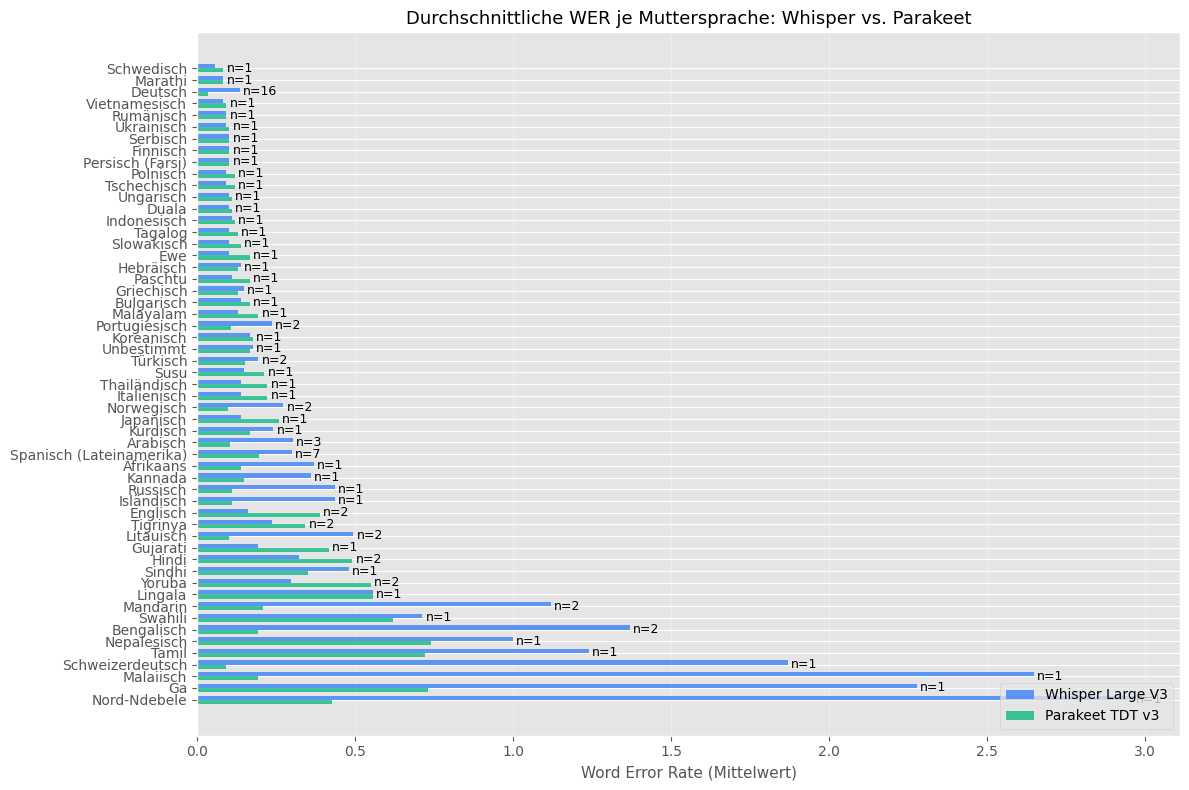

In [30]:
plot_df = language_overview
if plot_df.empty:
    print("Keine Sprachgruppen erfüllen die Mindestanzahl für die Visualisierung.")
elif has_parakeet:
    # Grouped Bar Chart für beide Modelle
    fig, ax = plt.subplots(figsize=(12, 8))
    
    languages = plot_df.index
    x = list(range(len(languages)))
    width = 0.35
    
    # Balken für beide Modelle
    whisper_bars = ax.barh([i - width/2 for i in x], plot_df["whisper_mean"], 
                            height=width, color="#3B82F6", alpha=0.8, label="Whisper Large V3")
    parakeet_bars = ax.barh([i + width/2 for i in x], plot_df["parakeet_mean"], 
                             height=width, color="#10B981", alpha=0.8, label="Parakeet TDT v3")
    
    # Sample-Zahlen anzeigen
    for i, (w_mean, p_mean, samples) in enumerate(zip(plot_df["whisper_mean"], 
                                                        plot_df["parakeet_mean"], 
                                                        plot_df["samples"])):
        max_val = max(w_mean, p_mean)
        ax.text(max_val + 0.01, i, f"n={samples}", va="center", fontsize=9)
    
    ax.set_yticks(x)
    ax.set_yticklabels(languages)
    ax.set_xlabel("Word Error Rate (Mittelwert)", fontsize=11)
    ax.set_title("Durchschnittliche WER je Muttersprache: Whisper vs. Parakeet", fontsize=13)
    ax.invert_yaxis()
    ax.legend(loc="lower right")
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
else:
    # Nur Whisper (Fallback)
    fig, ax = plt.subplots(figsize=(10, 6))
    y_positions = list(range(len(plot_df)))
    ax.barh(y_positions, plot_df["mean_wer"], color="#2563EB", alpha=0.8, label="Mittelwert")
    for idx, (lower, upper) in enumerate(zip(plot_df["wer_p25"], plot_df["wer_p75"])):
        ax.hlines(idx, lower, upper, color="#F97316", linewidth=4, label="IQR" if idx == 0 else "")
    for idx, (mean, samples) in enumerate(zip(plot_df["mean_wer"], plot_df["samples"])):
        ax.text(mean + 0.005, idx, f"n={samples}", va="center", fontsize=9)
    ax.set_yticks(y_positions)
    ax.set_yticklabels(plot_df.index)
    ax.set_xlabel("Word Error Rate")
    ax.set_title("Durchschnittliche WER je Muttersprache (IQR als Linie)")
    ax.invert_yaxis()
    ax.legend(loc="lower right")
    plt.tight_layout()

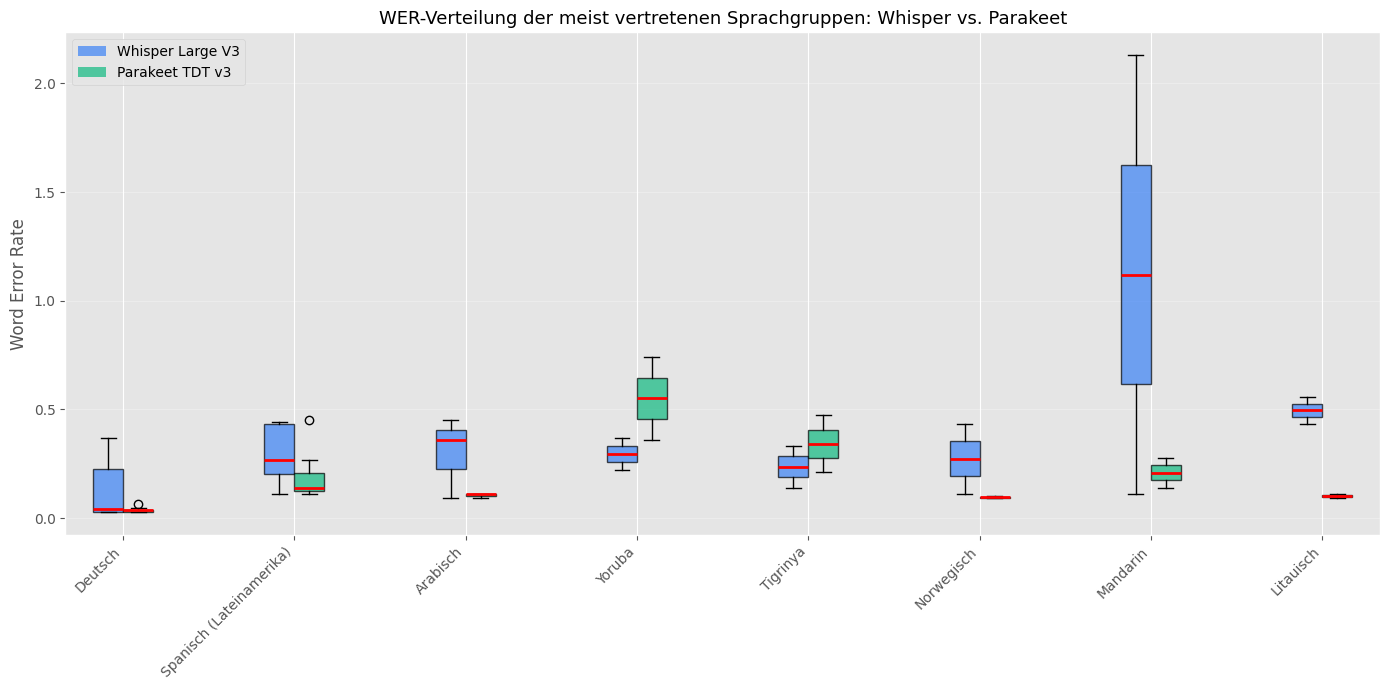

In [31]:
top_groups = metrics.sort_values("samples", ascending=False).head(8).index
subset = df[df["language_group"].isin(top_groups)].copy()

if subset.empty:
    print("Keine ausreichenden Daten für die Boxplot-Visualisierung.")
elif has_parakeet:
    # Boxplots für beide Modelle nebeneinander
    subset["language_group"] = pd.Categorical(subset["language_group"], categories=top_groups, ordered=True)
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Manueller grouped boxplot
    whisper_positions = []
    parakeet_positions = []
    box_width = 0.35
    
    for i in range(len(top_groups)):
        whisper_positions.append(i * 2 - box_width/2)
        parakeet_positions.append(i * 2 + box_width/2)
    
    # Whisper Boxplots
    whisper_boxdata = [subset[subset["language_group"] == g]["whisper_large_v3_wer"].dropna().values 
                       for g in top_groups]
    bp1 = ax.boxplot(whisper_boxdata, positions=whisper_positions, widths=box_width,
                     patch_artist=True, boxprops=dict(facecolor="#3B82F6", alpha=0.7),
                     medianprops=dict(color="red", linewidth=2))
    
    # Parakeet Boxplots
    parakeet_boxdata = [subset[subset["language_group"] == g]["parakeet_tdt_v3_wer"].dropna().values 
                        for g in top_groups]
    bp2 = ax.boxplot(parakeet_boxdata, positions=parakeet_positions, widths=box_width,
                     patch_artist=True, boxprops=dict(facecolor="#10B981", alpha=0.7),
                     medianprops=dict(color="red", linewidth=2))
    
    # X-Achse konfigurieren
    ax.set_xticks([i * 2 for i in range(len(top_groups))])
    ax.set_xticklabels(top_groups, rotation=45, ha="right")
    ax.set_ylabel("Word Error Rate")
    ax.set_title("WER-Verteilung der meist vertretenen Sprachgruppen: Whisper vs. Parakeet", fontsize=13)
    
    # Legende
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#3B82F6', alpha=0.7, label='Whisper Large V3'),
                      Patch(facecolor='#10B981', alpha=0.7, label='Parakeet TDT v3')]
    ax.legend(handles=legend_elements, loc='upper left')
    
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
else:
    # Nur Whisper (Fallback)
    subset["language_group"] = pd.Categorical(subset["language_group"], categories=top_groups, ordered=True)
    fig, ax = plt.subplots(figsize=(10, 6))
    subset.boxplot(column="whisper_large_v3_wer", by="language_group", ax=ax, grid=False)
    ax.set_ylabel("Word Error Rate")
    ax.set_xlabel("Muttersprache")
    ax.set_title("WER-Verteilung der meist vertretenen Sprachgruppen")
    plt.suptitle("")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

MODELL-PERFORMANCE PRO SPRACHGRUPPE

Whisper gewinnt bei: 24 Sprachen
Parakeet gewinnt bei: 25 Sprachen
Unentschieden: 6 Sprachen

Durchschnittliche absolute Differenz: 0.282

Top 10 größte Unterschiede:
                  whisper_mean  parakeet_mean  wer_diff    winner
language_group                                                   
Nord-Ndebele             2.963          0.426    -2.537  Parakeet
Malaiisch                2.648          0.194    -2.454  Parakeet
Schweizerdeutsch         1.870          0.093    -1.778  Parakeet
Ga                       2.278          0.731    -1.546  Parakeet
Bengalisch               1.370          0.194    -1.176  Parakeet
Mandarin                 1.120          0.208    -0.912  Parakeet
Tamil                    1.241          0.722    -0.519  Parakeet
Litauisch                0.495          0.102    -0.394  Parakeet
Russisch                 0.435          0.111    -0.324  Parakeet
Isländisch               0.435          0.111    -0.324  Parakeet


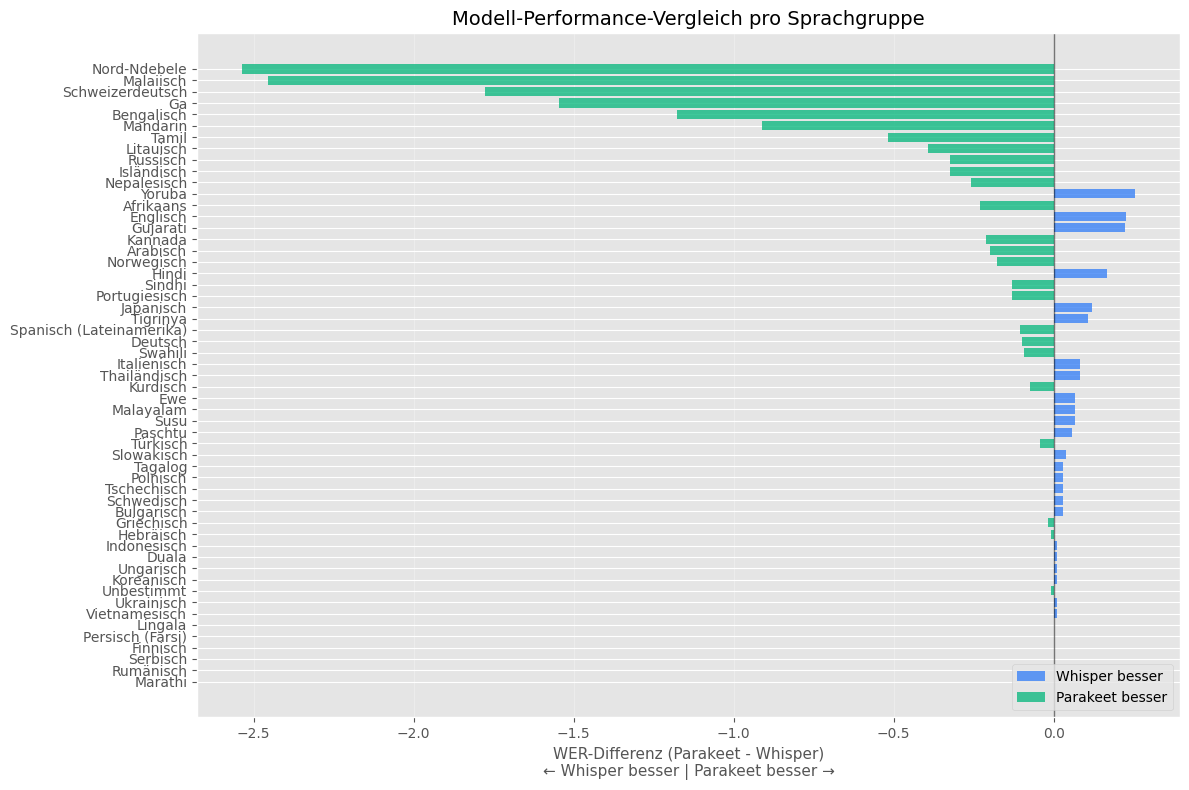

In [32]:
if has_parakeet:
    # Performance-Gewinner-Analyse: Welches Modell ist bei welcher Sprache besser?
    winner_df = language_overview[["samples", "whisper_mean", "parakeet_mean", "wer_diff"]].copy()
    winner_df["winner"] = winner_df["wer_diff"].apply(
        lambda x: "Whisper" if x > 0 else ("Parakeet" if x < 0 else "Gleich")
    )
    winner_df["abs_diff"] = winner_df["wer_diff"].abs()
    
    # Nach größter absoluter Differenz sortieren
    winner_df_sorted = winner_df.sort_values("abs_diff", ascending=False)
    
    print("=" * 80)
    print("MODELL-PERFORMANCE PRO SPRACHGRUPPE")
    print("=" * 80)
    print(f"\nWhisper gewinnt bei: {(winner_df['winner'] == 'Whisper').sum()} Sprachen")
    print(f"Parakeet gewinnt bei: {(winner_df['winner'] == 'Parakeet').sum()} Sprachen")
    print(f"Unentschieden: {(winner_df['winner'] == 'Gleich').sum()} Sprachen")
    print(f"\nDurchschnittliche absolute Differenz: {winner_df['abs_diff'].mean():.3f}")
    print("\nTop 10 größte Unterschiede:")
    print(winner_df_sorted[["whisper_mean", "parakeet_mean", "wer_diff", "winner"]].head(10))
    
    # Visualisierung: WER-Differenz pro Sprache
    fig, ax = plt.subplots(figsize=(12, 8))
    
    languages = winner_df_sorted.index
    diffs = winner_df_sorted["wer_diff"]
    colors = ["#3B82F6" if d > 0 else "#10B981" for d in diffs]
    
    y_pos = list(range(len(languages)))
    ax.barh(y_pos, diffs, color=colors, alpha=0.8)
    
    # Null-Linie
    ax.axvline(0, color='black', linewidth=1, linestyle='-', alpha=0.5)
    
    # Beschriftungen
    ax.set_yticks(y_pos)
    ax.set_yticklabels(languages)
    ax.set_xlabel("WER-Differenz (Parakeet - Whisper)\n← Whisper besser | Parakeet besser →", fontsize=11)
    ax.set_title("Modell-Performance-Vergleich pro Sprachgruppe", fontsize=14)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    # Legende
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#3B82F6', alpha=0.8, label='Whisper besser'),
        Patch(facecolor='#10B981', alpha=0.8, label='Parakeet besser')
    ]
    ax.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    
    winner_df_sorted

L1 vs. L2 DEUTSCH: MODELLVERGLEICH
              samples  whisper_mean  whisper_std  parakeet_mean  parakeet_std  \
is_german_l1                                                                    
Deutsch L2         72         0.435        0.642          0.226         0.181   
Deutsch L1         16         0.135        0.128          0.036         0.010   

              wer_diff  
is_german_l1            
Deutsch L2      -0.208  
Deutsch L1      -0.100  


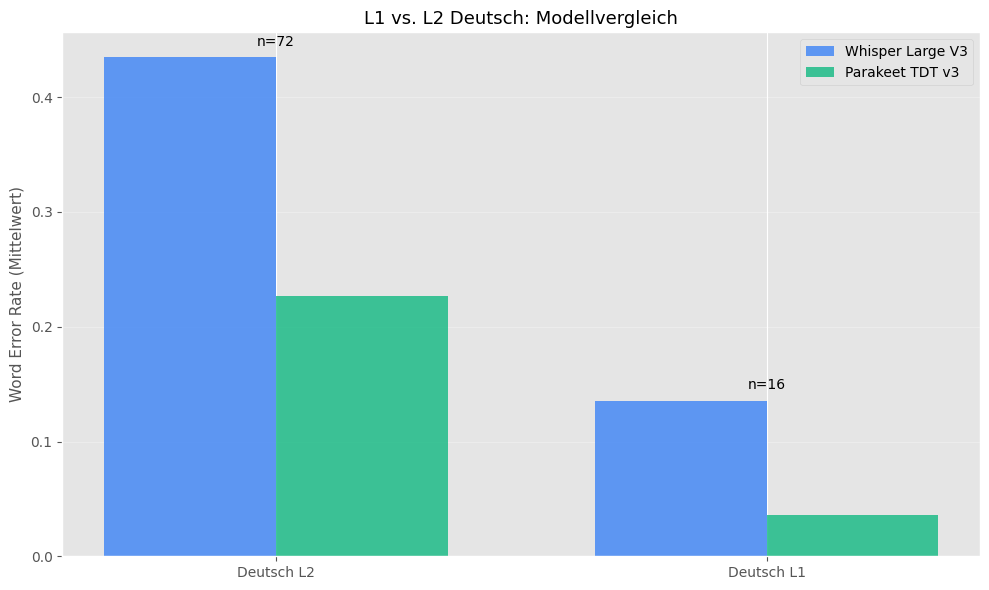

In [33]:
# L1 vs. L2 Deutsch-Analyse
if has_parakeet:
    l1_l2_metrics = (
        df.dropna(subset=["whisper_large_v3_wer", "parakeet_tdt_v3_wer"])
          .groupby("is_german_l1")
          .agg(
              samples=("whisper_large_v3_wer", "count"),
              whisper_mean=("whisper_large_v3_wer", "mean"),
              whisper_std=("whisper_large_v3_wer", "std"),
              parakeet_mean=("parakeet_tdt_v3_wer", "mean"),
              parakeet_std=("parakeet_tdt_v3_wer", "std"),
          )
    )
    
    l1_l2_metrics.index = l1_l2_metrics.index.map({True: "Deutsch L1", False: "Deutsch L2"})
    l1_l2_metrics["wer_diff"] = l1_l2_metrics["parakeet_mean"] - l1_l2_metrics["whisper_mean"]
    
    print("=" * 80)
    print("L1 vs. L2 DEUTSCH: MODELLVERGLEICH")
    print("=" * 80)
    print(l1_l2_metrics.round(3))
    
    # Visualisierung
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x_pos = [0, 1]
    width = 0.35
    
    whisper_means = l1_l2_metrics["whisper_mean"].values
    parakeet_means = l1_l2_metrics["parakeet_mean"].values
    labels = l1_l2_metrics.index.tolist()
    
    ax.bar([x - width/2 for x in x_pos], whisper_means, width, 
           label='Whisper Large V3', color='#3B82F6', alpha=0.8)
    ax.bar([x + width/2 for x in x_pos], parakeet_means, width,
           label='Parakeet TDT v3', color='#10B981', alpha=0.8)
    
    ax.set_ylabel('Word Error Rate (Mittelwert)', fontsize=11)
    ax.set_title('L1 vs. L2 Deutsch: Modellvergleich', fontsize=13)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Sample-Zahlen als Text
    for i, (w, p, n) in enumerate(zip(whisper_means, parakeet_means, l1_l2_metrics["samples"])):
        max_val = max(w, p)
        ax.text(i, max_val + 0.01, f"n={n}", ha='center', fontsize=10)
    
    plt.tight_layout()
else:
    l1_l2_metrics = (
        df.dropna(subset=["whisper_large_v3_wer"])
          .groupby("is_german_l1")
          .agg(
              samples=("whisper_large_v3_wer", "count"),
              mean_wer=("whisper_large_v3_wer", "mean"),
              std_wer=("whisper_large_v3_wer", "std"),
          )
    )
    
    l1_l2_metrics.index = l1_l2_metrics.index.map({True: "Deutsch L1", False: "Deutsch L2"})
    
    print("=" * 80)
    print("L1 vs. L2 DEUTSCH")
    print("=" * 80)
    print(l1_l2_metrics.round(3))